In [1]:
##%matplotlib widget
##%load_ext autoreload
##%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#from matplotlib.animation import FuncAnimation
import matplotlib.ticker as mticker
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata
import xgcm
from scipy.interpolate import interp1d
import re
import datetime as dt
import sys
from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
import cartopy as cart
import ecco_v4_py as ecco
import seaborn as sns
sns.set_context(context='paper', font_scale=1.5)
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat
import mat73
import MITgcmutils as mit

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
deltat=1800.
ny, nx = 270*13, 270
# prefix=['diagsKrN2']

rhoConst=1035.
gravity = 9.81
grho = rhoConst*gravity

landcolor = 'lightgrey'

In [5]:
%run losch_plotting_funcs.ipynb

In [6]:
### Load grid and old bathymetry

rdir = '/albedo/work/user/ndettlin/MITgcm/verification/global/run/gm_200_taper_sa/'
ds = open_mdsdataset(rdir,prefix=['diags3D'],delta_t=1800,geometry='llc', ignore_unknown_vars=True)

llc270_extra_metadata = get_extra_metadata(domain='llc', nx=270)
grid = get_grid_from_input(os.path.join('/albedo/home/mlosch/MITgcm/MITgcm/llc270/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc270_extra_metadata)


# find out the file numbers to read
d00 = open_mdsdataset(rdir,prefix=['3d_diag_z'],delta_t=1800,geometry='llc')
coords = d00.coords.to_dataset().reset_coords()

# important: create grid object before fixing any coordinates
grd = xgcm.Grid(coords, periodic=False, face_connections=face_connections)

coords['XC'] = grid.XC
coords['YC'] = grid.YC
coords['XG'] = grid.XG
coords['YG'] = grid.YG

prefix = list(ds.keys())
ds[prefix] = ds[prefix].where(ds[prefix] != 0)

### some plotting stuff
mapper = LLCMapper(coords)
mapper_2 = LLCMapper_2(coords)
mapper_noland = LLCMapper_noland(coords)


proj_glob=cart.crs.EqualEarth() #central_longitude=180.0-19) #central_longitude=7.0)
proj_antarctic=cart.crs.Stereographic(central_latitude=-87.8, central_longitude=0.0)
proj_arctic=cart.crs.NorthPolarStereo(central_longitude=-30)

msk = ds.maskC[0,...].compute()
rac = (ds.rA*ds.maskC[0,...]).compute()

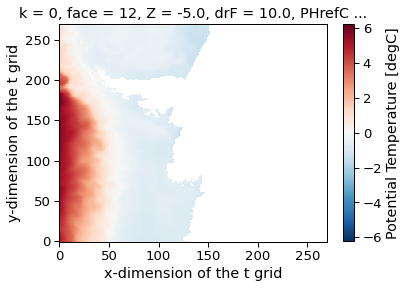

In [7]:
ds.THETA.isel(time=0, k=0, face=12).plot()

In [8]:
#tis = ds.THETA.isel(face=12, time=0, i=50, j=50).compute()
#sis = ds.SALT.isel(face=12, time=0, i=50, j=50).compute()

sis = 34.8*np.ones(50)
tis = -2.2*np.ones(50)

In [9]:
dz = np.array([10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
     10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
     31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
     93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
     139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
     341.50,364.50,387.50,410.50,433.50,456.50])

def myround(v,prec=4):
    return np.format_float_positional(v,
                                      precision=prec,
                                      unique=False,
                                      fractional=False,
                                      trim ='k')

for k in range(len(dz)):
    dz[k] = myround(dz[k])
    

zf = - np.hstack((0,dz.cumsum()))
zc = 0.5*(zf[:-1]+zf[1:])
nz = len(zc)

# ice mass
rhoConst=1030.
gravity=9.81

k=0
dzm = np.abs(np.hstack((zf[0]-zc[0],.5*np.diff(zc))))
dzp = np.abs(np.hstack((.5*np.diff(zc),zc[-1]-zf[-1])))
p = np.abs(zc)*gravity*rhoConst*1e-4
dp = np.copy(p)

def rms(v):
    return np.sqrt(np.sum(v.ravel()**2/len(v.ravel())))

phiHydF = np.zeros((nz+1,))
phiHydC = np.zeros((nz,))
kp = 0
eos = 'linear'
eos = 'teos10'
print('eosType = ',eos)
dp

eosType =  teos10


array([5.05215000e+00, 1.51564500e+01, 2.52607500e+01, 3.53650500e+01,
       4.54693500e+01, 5.55736500e+01, 6.56779500e+01, 7.57873022e+01,
       8.59118108e+01, 9.60868409e+01, 1.06408383e+02, 1.17078524e+02,
       1.28476175e+02, 1.41197488e+02, 1.56081122e+02, 1.74198132e+02,
       1.96766086e+02, 2.25032865e+02, 2.60155412e+02, 3.03058270e+02,
       3.54337592e+02, 4.14205570e+02, 4.82450012e+02, 5.58474765e+02,
       6.41355286e+02, 7.29934632e+02, 8.22964922e+02, 9.19228588e+02,
       1.01765963e+03, 1.11743959e+03, 1.21810368e+03, 1.31980346e+03,
       1.42382723e+03, 1.53290314e+03, 1.65117398e+03, 1.78348978e+03,
       1.93404385e+03, 2.10566539e+03, 2.29987004e+03, 2.51716301e+03,
       2.75764535e+03, 3.02136758e+03, 3.30832970e+03, 3.61853171e+03,
       3.95197361e+03, 4.30865540e+03, 4.68857708e+03, 5.09173865e+03,
       5.51814011e+03, 5.96778146e+03])

In [10]:
while rms(dp) > 1e-13:
    phiHydF[k] = 0;
    p0 = np.copy(p)
    kp = kp+1
    if eos == 'linear':
        talpha = 2e-4;
        sbeta  = 7.4e-4;
        tref = -1.9*np.ones((nz,));
        tref = 34.4*np.ones((nz,));
        drho = rhoConst*(1. -talpha*(tis-tref) + sbeta*(sis-sref))-rhoConst
    elif eos == 'jmd95z':
        drho = mit.dens.jmd95(sis,tis,p)-rhoConst
    elif eos == 'mdjwf':
        drho = mit.dens.mdjwf(sis,tis,p)-rhoConst
    elif eos == 'teos10':
        drho = mit.dens.teos10(sis,tis,p)-rhoConst
    else:
        print('unknown EOS: %s'%eos)

    for k in range(nz):
        phiHydC[k]   = phiHydF[k] + dzm[k]*gravity*drho[k]/rhoConst
        phiHydF[k+1] = phiHydC[k] + dzp[k]*gravity*drho[k]/rhoConst

    p = (gravity*rhoConst*np.abs(zc) + phiHydC*rhoConst)/gravity/rhoConst;
    dp = p-p0

dp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
nx = 10
ny = 10
icedraft = np.zeros([10,10]) + 100

hf = mit.rdmds(os.path.join(rdir,'hFacC'))
msk=np.sum(hf,axis=0)
msk[msk>0]=1
phi0surf = np.zeros((ny,nx))

for ix in range(nx):
    for iy in range(ny):
        k=np.argwhere(np.abs(zf)<np.abs(icedraft[iy,ix]))
        if len(k)>0:
            k=max(k)
            kp1=min(k+1,nz);
            drloc=1. - hf[k,iy,ix]
            # drloc=(np.abs(icedraft[iy,ix])-np.abs(zf[k]))/dz[k]
            dphi = phiHydF[kp1]-phiHydF[k]
            phi0surf[iy,ix] = (phiHydF[k]+drloc*dphi)*rhoConst*msk[iy,ix]
            
rSurf0 = mit.rdmds(os.path.join(rdir,'rSurfC'))
pLoadAn=phi0surf
mIce=phi0surf/gravity-rSurf0*rhoConst;


OSError: No files found for /albedo/work/user/ndettlin/MITgcm/verification/global/run/gm_200_taper_sa/rSurfC.meta

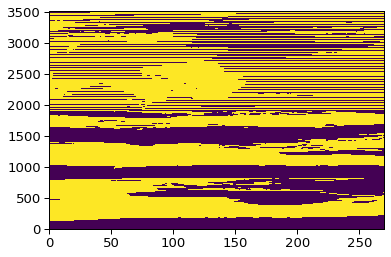

In [12]:
plt.pcolormesh(msk)

In [14]:
msk.shape

(3510, 270)